# K-Means

## 1. Introdução

Neste notebook, exploraremos o algoritmo de clusterização K-Means, um dos mais fundamentais e amplamente utilizados em aprendizado não supervisionado. O objetivo do K-Means é particionar um conjunto de $N$ observações em $K$ clusters distintos, onde cada observação pertence ao cluster com a média (centróide) mais próxima.

O algoritmo opera de forma iterativa para atribuir cada ponto de dado a um dos $K$ grupos com base nas características fornecidas. Os centróides são então recalculados como a média dos pontos de dados atribuídos a cada cluster. Este processo de duas etapas, atribuição e atualização, continua até que a alocação dos pontos aos clusters não mude mais, ou seja, até a convergência.

### Conteúdos abordados:

* **Fundamentação Matemática**: A função objetivo do K-Means.
* **Implementação em Python**: Construção do algoritmo passo a passo usando apenas a biblioteca NumPy.
* **Visualização de Dados**: Carregamento e preparação de um dataset real.
* **Passos do Algoritmo**:
    1.  Inicialização dos centróides.
    2.  Atribuição de clusters.
    3.  Atualização dos centróides.
* **Visualização dos Resultados**: Análise gráfica dos clusters formados.

In [1]:
# Célula de importação de bibliotecas

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Fundamentação Matemática do K-Means

O K-Means busca minimizar a variância intra-cluster, também conhecida como Inércia ou Soma dos Quadrados Dentro do Cluster (WCSS - Within-Cluster Sum of Squares). A função objetivo pode ser formalmente expressa como:

$$ J = \sum_{k=1}^{K} \sum_{i \in C_k} || \mathbf{x}_i - \boldsymbol{\mu}_k ||^2 $$

Onde:
- $K$ é o número de clusters.
- $C_k$ é o conjunto de todas as observações pertencentes ao cluster $k$.
- $\mathbf{x}_i$ é o vetor que representa a $i$-ésima observação.
- $\boldsymbol{\mu}_k$ é o centróide (média) do cluster $k$.
- $||\mathbf{x}_i - \boldsymbol{\mu}_k||^2$ é a distância Euclidiana ao quadrado entre a observação $\mathbf{x}_i$ e o centróide $\boldsymbol{\mu}_k$.

### O Processo Iterativo de Otimização

O algoritmo utiliza um procedimento iterativo de otimização conhecido como Expectation-Maximization (EM):
1.  **Passo de Atribuição (Expectation)**: Cada observação é atribuída ao cluster cujo centróide é o mais próximo. Esta etapa define os limites de decisão.
    $$ C_k = \{ i : ||\mathbf{x}_i - \boldsymbol{\mu}_k||^2 \le ||\mathbf{x}_i - \boldsymbol{\mu}_j||^2 \quad \forall j, 1 \le j \le K \} $$
2.  **Passo de Atualização (Maximization)**: Os centróedes são recalculados como a média de todas as observações atribuídas ao seu cluster. Esta etapa move os centróides para o centro de suas novas nuvens de pontos.
    $$ \boldsymbol{\mu}_k = \frac{1}{|C_k|} \sum_{i \in C_k} \mathbf{x}_i $$

Esses dois passos são repetidos até a convergência, que é alcançada quando as atribuições dos pontos de dados não mudam mais entre as iterações.

## 3. Preparação dos Dados

Para este exercício, utilizaremos o famoso dataset *Iris*, que contém medições de três espécies de flores. Embora este dataset seja classicamente usado para tarefas de classificação (supervisionadas), ele serve como um excelente exemplo para a clusterização, pois podemos avaliar visualmente a capacidade do K-Means em separar as espécies com base apenas em suas características.

Vamos carregar os dados e selecionar duas características (comprimento e largura da sépala) para facilitar a visualização em um plano 2D.

### 3.1 Análise Exploratória: Escolhendo as Melhores Features

Como podemos saber quais features são mais promissoras para a clusterização? Uma técnica visual poderosa é o **gráfico de pares (pair plot)**. Este tipo de gráfico mostra um scatter plot para cada par de features do dataset. Ele nos permite inspecionar visualmente a separação entre os grupos em diferentes subespaços 2D dos dados.

Para o K-Means, procuramos por pares de features que mostrem aglomerados de pontos visualmente distintos e compactos.

Vamos usar a biblioteca `seaborn` para criar um `pairplot` do dataset Iris. Para tornar a visualização mais clara, vamos colorir os pontos de acordo com suas espécies reais. Em um problema real não supervisionado, não teríamos esses rótulos, mas aqui eles servem como um guia para validarmos nossa escolha.

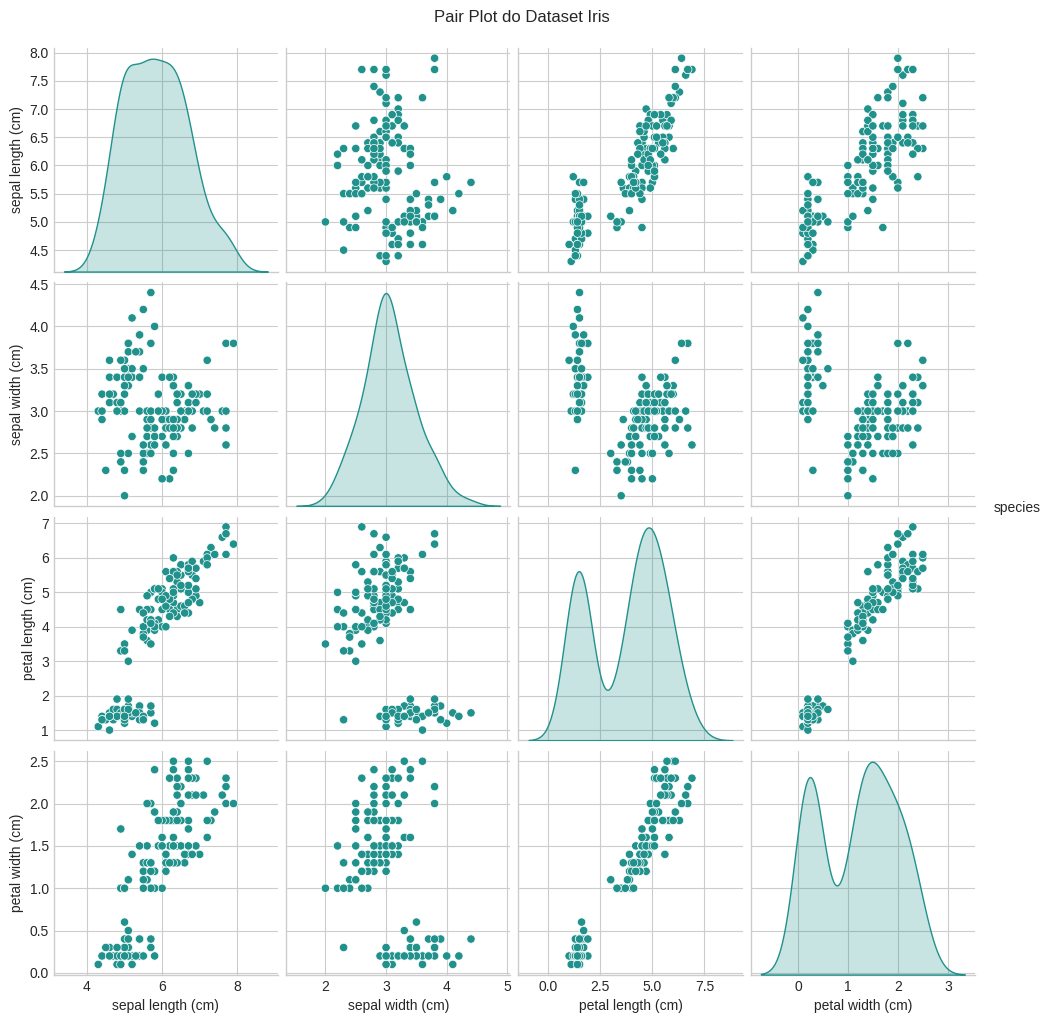

In [2]:
import seaborn as sns
import pandas as pd

# Carregar o dataset Iris
iris = load_iris()
X = iris.data
y_true = iris.target

# Para facilitar o uso com o Seaborn, vamos criar um DataFrame do Pandas
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = pd.Series(iris.target).map({0: '', 1: '', 2: ''}) #.map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Gerar o pairplot
# O hue='species' colore os pontos de acordo com a espécie real da flor
sns.pairplot(iris_df, hue='species', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot do Dataset Iris', y=1.02) # Ajusta o título para não sobrepor
plt.show()

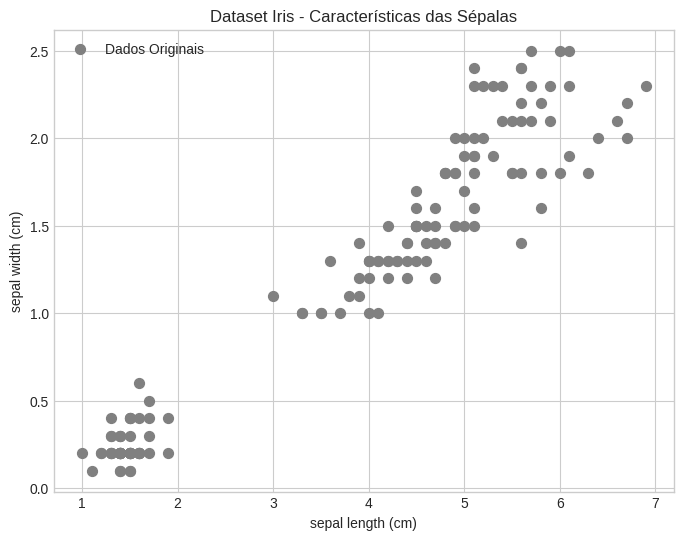

In [3]:
# Carregar o dataset Iris
iris = load_iris()
X = iris.data
y_true = iris.target

# Para fins de visualização, vamos usar apenas as duas primeiras features:
# Comprimento da sépala (sepal length) e Largura da sépala (sepal width)
X = X[:, 2:]

# Visualizar os dados
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='gray', marker='o', s=50, label='Dados Originais')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title('Dataset Iris - Características das Sépalas')
plt.legend()
plt.show()

## 4. Implementação do Algoritmo K-Means

Agora, vamos construir uma classe `KMeans` do zero. A estrutura da classe conterá os métodos essenciais para a execução do algoritmo.

### 4.1 Definição da Classe

A classe `KMeans` armazenará os hiperparâmetros, os centróides e os rótulos. Ela conterá os métodos para inicializar os centróides, atribuir clusters, atualizar os centróides e orquestrar o treinamento.

In [4]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """
        Inicializa os centróides selecionando K pontos aleatórios do dataset.
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

    def _assign_clusters(self, X):
        """
        Atribui cada ponto de dado ao centróide mais próximo.
        """
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, self.n_clusters))

        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)
        
        self.labels = np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        """
        Atualiza a posição de cada centróide com base na média dos pontos atribuídos a ele.
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        
        for i in range(self.n_clusters):
            cluster_points = X[self.labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[i] = self.centroids[i]
        
        self.centroids = new_centroids

    def fit(self, X):
        """
        Executa o algoritmo K-Means.
        """
        self._initialize_centroids(X)

        for _ in range(self.max_iter):
            old_centroids = self.centroids.copy()
            self._assign_clusters(X)
            self._update_centroids(X)
            if np.allclose(old_centroids, self.centroids):
                break

    def predict(self, X):
        """
        Atribui clusters para novos dados com base nos centróides aprendidos.
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)
        
        return np.argmin(distances, axis=1)

## 5. Treinando o Modelo e Visualizando os Resultados

Com a classe `KMeans` definida, o próximo passo é instanciá-la, treinar o modelo com nossos dados e, finalmente, visualizar os clusters que o algoritmo identificou.

### 5.1 Instanciando e Treinando o Modelo
Primeiro, criamos uma instância da nossa classe `KMeans`, especificando o número de clusters desejado ($K=3$, pois sabemos que o dataset Iris possui 3 espécies), e em seguida chamamos o método `fit` para executar o algoritmo.

In [5]:
# Instanciar e treinar o modelo K-Means
kmeans = KMeans(n_clusters=3, max_iter=150, random_state=42)
kmeans.fit(X)

### 5.2 Extraindo os Resultados
Após o treinamento, os centróides finais e os rótulos de cada ponto de dado estão armazenados dentro do objeto `kmeans`. Vamos extraí-los para poder visualizá-los.

In [6]:
# Obter os centróides finais e os rótulos dos clusters
final_centroids = kmeans.centroids
predicted_labels = kmeans.labels

print("Coordenadas dos Centróides Finais:")
print(final_centroids)

Coordenadas dos Centróides Finais:
[[4.29259259 1.35925926]
 [1.462      0.246     ]
 [5.62608696 2.04782609]]


### 5.3 Visualização dos Clusters
Com os rótulos e centróides em mãos, podemos gerar um gráfico de dispersão para visualizar os clusters identificados pelo algoritmo. Cada cluster será representado por uma cor diferente, e os centróides finais serão destacados com um marcador especial.

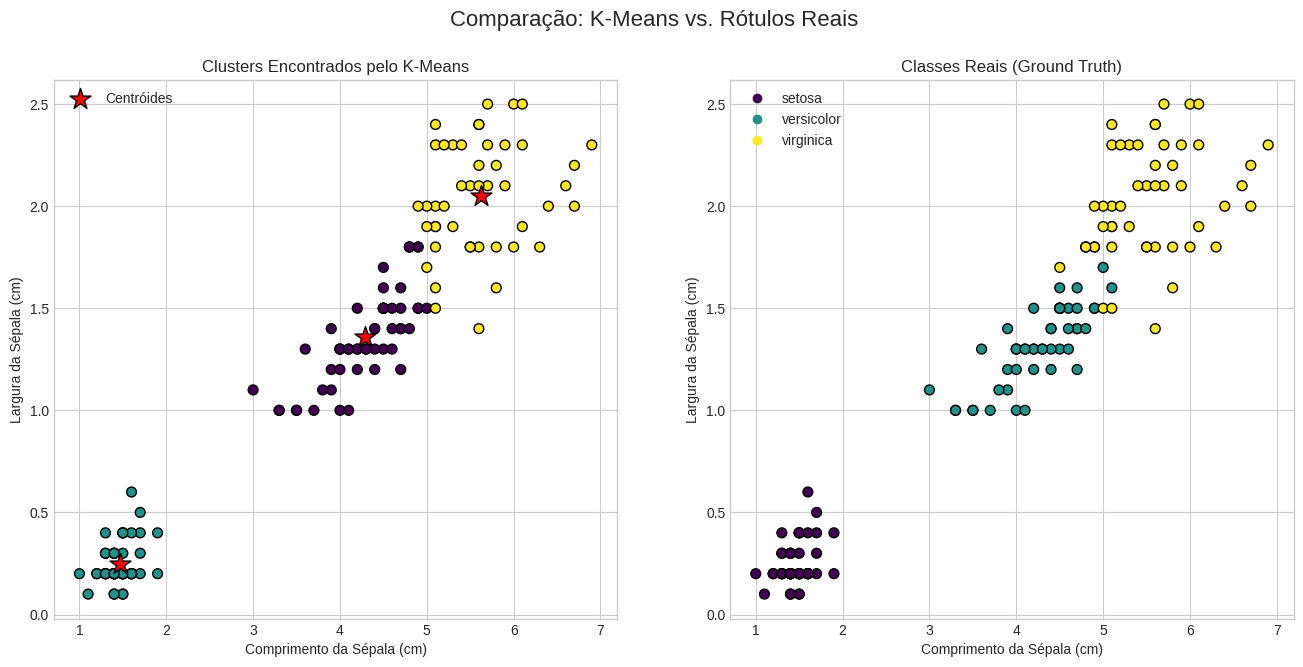

In [7]:
# Configurar a figura para plots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Clusters encontrados pelo K-Means
axes[0].scatter(X[:, 0], X[:, 1], c=predicted_labels, s=50, cmap='viridis', edgecolor='k')
axes[0].scatter(final_centroids[:, 0], final_centroids[:, 1], s=250, marker='*', c='red', edgecolor='black', label='Centróides')
axes[0].set_title('Clusters Encontrados pelo K-Means')
axes[0].set_xlabel('Comprimento da Sépala (cm)')
axes[0].set_ylabel('Largura da Sépala (cm)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Classes Reais do Dataset
scatter = axes[1].scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title('Classes Reais (Ground Truth)')
axes[1].set_xlabel('Comprimento da Sépala (cm)')
axes[1].set_ylabel('Largura da Sépala (cm)')
axes[1].legend(handles=scatter.legend_elements()[0], labels=iris.target_names.tolist())
axes[1].grid(True)

plt.suptitle('Comparação: K-Means vs. Rótulos Reais', fontsize=16)
plt.show()

### 5.4 Contagem de Acertos

Como os rótulos dos clusters (0, 1, 2...) são arbitrários e não correspondem diretamente aos rótulos reais das espécies, não podemos simplesmente compará-los.

Uma forma intuitiva de medir o resultado é verificar a "pureza" de cada cluster. Para cada cluster, vamos assumir que ele representa a espécie de flor que aparece com mais frequência dentro dele. Em seguida, contamos quantos pontos de dados nesse cluster realmente pertencem a essa espécie majoritária. A soma desses valores nos dará o número total de "acertos".

In [8]:
from scipy.stats import mode
import numpy as np

correct_predictions = 0
n_samples = X.shape[0]

# Para cada label de cluster (0, 1, 2...)
for i in range(kmeans.n_clusters):
    # 1. Encontra todos os pontos de dados que foram atribuídos ao cluster 'i'
    mask = (predicted_labels == i)
    
    # 2. Dentre esses pontos, descobre qual é a classe real mais comum (a moda)
    # Se a maioria dos pontos no cluster 'i' for da classe real 2, assumimos que 'i' corresponde a 2
    dominant_label = mode(y_true[mask], keepdims=True)[0][0]
    
    # 3. Conta quantos pontos nesse cluster realmente pertencem a essa classe dominante
    hits = np.sum(y_true[mask] == dominant_label)
    
    # 4. Adiciona essa contagem ao total de acertos
    correct_predictions += hits

print(f"Número de acertos: {correct_predictions} de {n_samples} pontos.")
print(f"Taxa de acerto: {(correct_predictions / n_samples):.2%}")

Número de acertos: 142 de 150 pontos.
Taxa de acerto: 94.67%


### 5.4 Visualização das Regiões de Decisão
Os centróides definem fronteiras no espaço de características. Qualquer ponto que cair dentro de uma determinada região será atribuído ao centróide correspondente. Essas regiões formam um Diagrama de Voronoi.

Para visualizar isso, podemos criar uma malha de pontos (meshgrid) que cobre todo o espaço do gráfico, usar nosso modelo treinado para prever o cluster de cada ponto na malha e, em seguida, colorir o fundo de acordo com essas previsões.

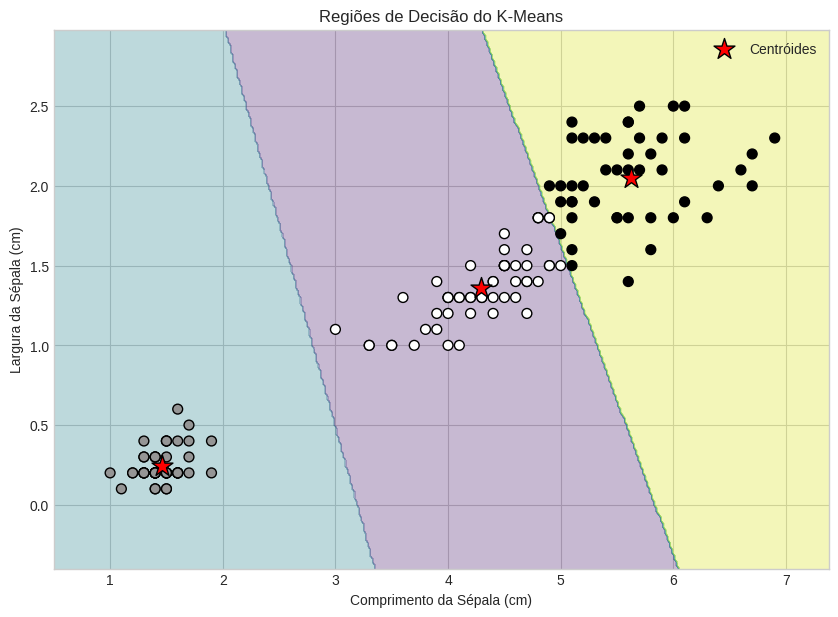

In [9]:
# Criar uma malha para cobrir o espaço do gráfico
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Usar o modelo para prever o cluster de cada ponto na malha
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotar o resultado
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, s=50, edgecolor='k')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], s=250, marker='*', c='red', edgecolor='black', label='Centróides')
plt.title('Regiões de Decisão do K-Means')
plt.xlabel('Comprimento da Sépala (cm)')
plt.ylabel('Largura da Sépala (cm)')
plt.legend()
plt.show()

## 6. O Método do Cotovelo (Elbow Method)

Até agora, definimos o número de clusters ($K$) como 3, pois já tínhamos um conhecimento prévio do dataset Iris. Em um problema real de aprendizado não supervisionado, o número ótimo de clusters é desconhecido.

O Método do Cotovelo é uma heurística utilizada para nos ajudar a encontrar um bom valor para $K$. A ideia é executar o algoritmo K-Means para um intervalo de valores de $K$ (por exemplo, de 1 a 10) e, para cada execução, calcular a inércia (WCSS).

$$ \text{Inércia} = \sum_{k=1}^{K} \sum_{i \in C_k} || \mathbf{x}_i - \boldsymbol{\mu}_k ||^2 $$

Ao plotar a inércia em função de $K$, o gráfico resultante geralmente se parece com um braço. O "cotovelo" nesse gráfico, o ponto onde a taxa de diminuição da inércia se torna abruptamente menor, é um bom candidato para o número ótimo de clusters. Isso ocorre porque adicionar mais clusters além do cotovelo não melhora significativamente a variância intra-cluster.

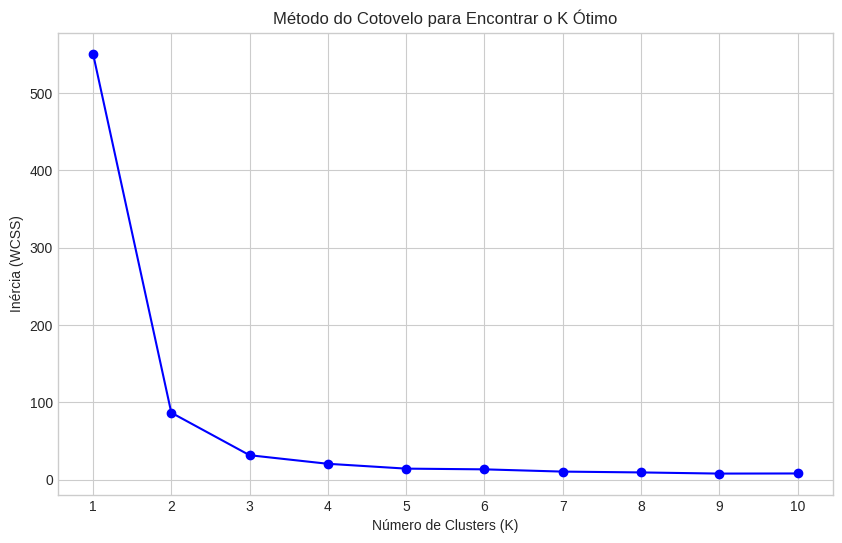

In [10]:
# Implementando o Método do Cotovelo com visualização iterativa
k_range = range(1, 11)
inertias = []
clustering_results = []

for k in k_range:
    model = KMeans(n_clusters=k, max_iter=150, random_state=42)
    model.fit(X)
    
    # Calcular a inércia (WCSS)
    current_inertia = 0
    for i in range(k):
        # Seleciona os pontos pertencentes ao cluster i
        cluster_points = X[model.labels == i]
        # Calcula a soma das distâncias quadradas ao centróide do cluster i
        current_inertia += np.sum((cluster_points - model.centroids[i])**2)
    
    inertias.append(current_inertia)
    clustering_results.append({'labels': model.labels, 'centroids': model.centroids})

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.title('Método do Cotovelo para Encontrar o K Ótimo')
plt.xticks(k_range)
plt.grid(True)
plt.show()

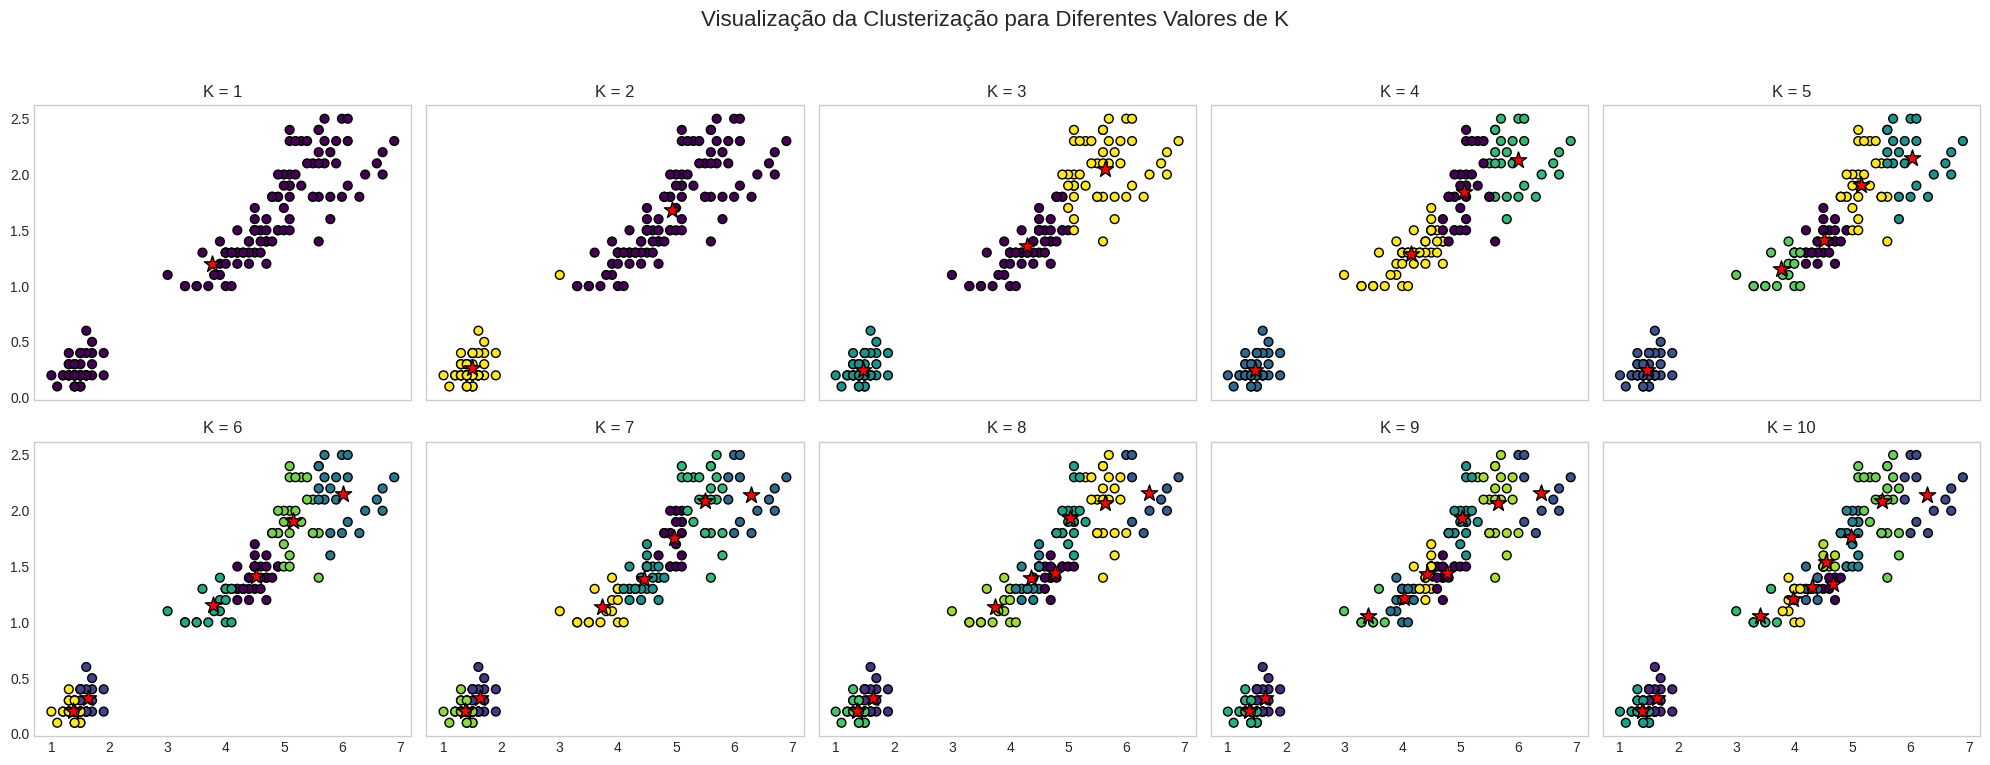

In [11]:
# Plotar os resultados da clusterização para cada K
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey=True)
axes = axes.ravel()

for i, k in enumerate(k_range):
    result = clustering_results[i]
    labels = result['labels']
    centroids = result['centroids']
    
    axes[i].scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', edgecolor='k')
    axes[i].scatter(centroids[:, 0], centroids[:, 1], marker='*', s=150, c='red', edgecolor='black')
    axes[i].set_title(f'K = {k}')
    axes[i].grid(False)

plt.suptitle('Visualização da Clusterização para Diferentes Valores de K', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Análise dos Gráficos

O primeiro gráfico, o do cotovelo, mostra claramente uma dobra acentuada em $K=3$. A partir deste ponto, a redução na inércia ao adicionar mais um cluster é muito menor, indicando que $K=3$ é uma escolha razoável.

A segunda série de gráficos reforça essa conclusão visualmente.
* Com $K=1$, todos os dados pertencem a um único grupo.
* Com $K=2$, o algoritmo separa o grupo mais distinto (setosa), mas ainda agrupa os outros dois (versicolor e virginica).
* Com $K=3$, a separação corresponde muito bem à estrutura real dos dados.
* Para $K>3$, o algoritmo começa a subdividir clusters que já são relativamente coesos, o que geralmente não é desejável e configura um "overfitting" do modelo de clusterização aos dados.

## 7. Aplicação 1: Compressão de Imagem (Quantização Vetorial)

Uma aplicação fascinante e não óbvia do K-Means é a compressão de imagens. A técnica, formalmente conhecida como **Quantização Vetorial**, utiliza a clusterização para reduzir o número de cores em uma imagem, diminuindo assim o espaço necessário para armazená-la.

A ideia central é a seguinte:
1.  Uma imagem digital colorida é uma matriz de pixels, onde cada pixel é um vetor, tipicamente com 3 dimensões (Vermelho, Verde, Azul - RGB). Uma imagem com milhões de pixels pode ter centenas de milhares de cores únicas.
2.  Podemos tratar cada pixel (vetor de cor) como um ponto de dado em um espaço 3D.
3.  O K-Means é então utilizado para agrupar essas cores em $K$ clusters. Os centróides desses clusters formarão a nossa nova "paleta de cores", contendo apenas $K$ cores representativas.
4.  Para comprimir a imagem, cada pixel original é substituído pela cor do centróide do cluster ao qual ele foi atribuído.

O resultado é uma imagem que utiliza apenas $K$ cores, mas que ainda se assemelha muito à original. A compressão ocorre porque, em vez de armazenar o valor RGB de cada pixel, precisamos apenas armazenar a paleta de $K$ cores e, para cada pixel, um índice (de 0 a $K-1$) apontando para a cor correspondente na paleta.

### 7.1 Carregando e Preparando a Imagem a partir de uma URL
Primeiro, vamos carregar uma imagem de exemplo diretamente de uma URL usando a biblioteca `imageio`. Em seguida, vamos remodelar a matriz da imagem (altura x largura x 3 canais de cor) para um formato 2D (número de pixels x 3 canais), que é o formato esperado pela nossa implementação do K-Means.

In [12]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np

# URL de uma imagem de alta qualidade para o exemplo
# (Exemplo: Uma paisagem com cores variadas)
image_url = "https://cdn.britannica.com/87/196687-138-2D734164/facts-parrots.jpg?w=800&h=450&c=crop"

# Ler a imagem diretamente da URL
source_image = imageio.imread(image_url)

# Normalizar os valores dos pixels para o intervalo [0, 1]
source_image = source_image / 255.0

# Obter as dimensões da imagem
height, width, channels = source_image.shape

# Remodelar a imagem para ser uma lista de pixels (vetores RGB)
pixel_list = source_image.reshape(-1, channels)

print(f"Dimensões originais da imagem: {source_image.shape}")
print(f"Dimensões da lista de pixels: {pixel_list.shape}")
print(f"Número de cores únicas na imagem original: {len(np.unique(pixel_list, axis=0))}")

Dimensões originais da imagem: (450, 800, 3)
Dimensões da lista de pixels: (360000, 3)
Número de cores únicas na imagem original: 203557


### 7.2 Aplicando K-Means para Criar a Paleta de Cores
Agora, vamos aplicar nosso algoritmo K-Means aos dados dos pixels. Para a tarefa de compressão, um número maior de clusters (cores) tende a preservar mais detalhes.

In [13]:
# Definir o número de clusters (cores na nova paleta)
K_compression = 8

# Instanciar e treinar um modelo K-Means específico para a compressão
compression_kmeans = KMeans(n_clusters=K_compression, max_iter=100, random_state=42)
compression_kmeans.fit(pixel_list)

# Os centróides encontrados formam a nossa nova paleta de cores
color_palette_compression = compression_kmeans.centroids

### 7.3 Reconstruindo a Imagem Comprimida
Com a paleta de 16 cores definida e cada pixel original atribuído a um cluster, podemos reconstruir a imagem. Criamos uma nova matriz de pixels onde cada pixel é substituído pela cor do centróide do seu cluster e, por fim, remodelamos a matriz de volta para as dimensões originais da imagem.

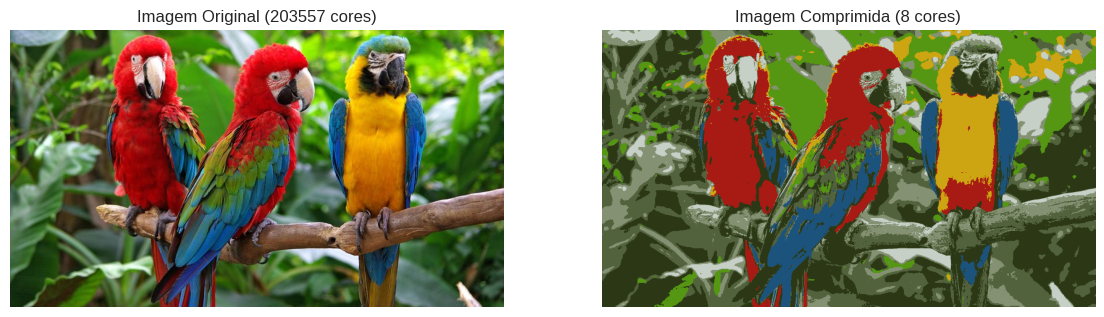

In [14]:
# Obter os rótulos de cluster para cada pixel
pixel_labels_compression = compression_kmeans.labels

# Criar a imagem comprimida substituindo cada pixel pelo seu centróide
compressed_pixel_list = color_palette_compression[pixel_labels_compression]

# Remodelar a lista de pixels de volta para o formato de imagem original
compressed_image = compressed_pixel_list.reshape(height, width, channels)

# Visualizar a imagem original e a imagem comprimida lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(source_image)
axes[0].set_title(f'Imagem Original ({len(np.unique(pixel_list, axis=0))} cores)')
axes[0].axis('off')

axes[1].imshow(compressed_image)
axes[1].set_title(f'Imagem Comprimida ({K_compression} cores)')
axes[1].axis('off')

plt.show()

## 8. Aplicação 2: Segmentação de Imagem
A segmentação de imagem é o processo de particionar uma imagem em múltiplos segmentos (conjuntos de pixels), com o objetivo de simplificar sua representação para facilitar a análise.

O K-Means pode ser usado para uma segmentação simples baseada em cores. Como o algoritmo agrupa pixels de cores semelhantes, os clusters resultantes correspondem naturalmente a diferentes regiões da imagem com perfis de cor distintos.

Para esta tarefa, um número menor de clusters é geralmente mais útil, pois nosso objetivo é identificar as macro-regiões da imagem.

### 8.1 Carregando a Imagem para Segmentação
Vamos carregar uma nova imagem de uma URL para demonstrar a segmentação. Esta imagem será processada da mesma forma que a imagem de compressão para extrair os dados de pixel.

In [15]:
image_url_segmentation = "https://www.letrasambientais.org.br/img/posts/PHYht7.png"

# Ler a imagem diretamente da URL
segmentation_source_image = imageio.imread(image_url_segmentation)

# Normalizar os valores dos pixels para o intervalo [0, 1]
segmentation_source_image = segmentation_source_image / 255.0

# Alguns arquivos PNG podem ter um canal Alpha (transparência), vamos garantir que usamos apenas RGB
if segmentation_source_image.shape[2] == 4:
    segmentation_source_image = segmentation_source_image[:, :, :3]

# Obter as dimensões da imagem para segmentação
seg_height, seg_width, seg_channels = segmentation_source_image.shape

# Remodelar a imagem para ser uma lista de pixels (vetores RGB)
pixel_list_segmentation = segmentation_source_image.reshape(-1, seg_channels)

print(f"Dimensões originais da imagem para segmentação: {segmentation_source_image.shape}")
print(f"Dimensões da lista de pixels para segmentação: {pixel_list_segmentation.shape}")

Dimensões originais da imagem para segmentação: (485, 800, 3)
Dimensões da lista de pixels para segmentação: (388000, 3)


### 8.2 Treinando um Modelo para Segmentação
Vamos treinar um novo modelo K-Means, desta vez com um número menor de clusters ($K=3$), para identificar as principais regiões de cor nesta nova imagem.

In [16]:
# Definir um número menor de clusters para a segmentação
K_segmentation = 3

# Instanciar e treinar um novo modelo K-Means específico para a segmentação
segmentation_kmeans = KMeans(n_clusters=K_segmentation, max_iter=100, random_state=42)
segmentation_kmeans.fit(pixel_list_segmentation)

### 8.3 Visualizando o Mapa de Segmentação
O array de `labels` resultante do nosso novo modelo contém o índice do segmento para cada pixel. Ao remodelar este array de volta às dimensões da imagem original, criamos um "mapa de segmentação", onde cada valor de pixel corresponde ao seu ID de segmento. Podemos colorir este mapa para uma visualização clara das regiões identificadas.

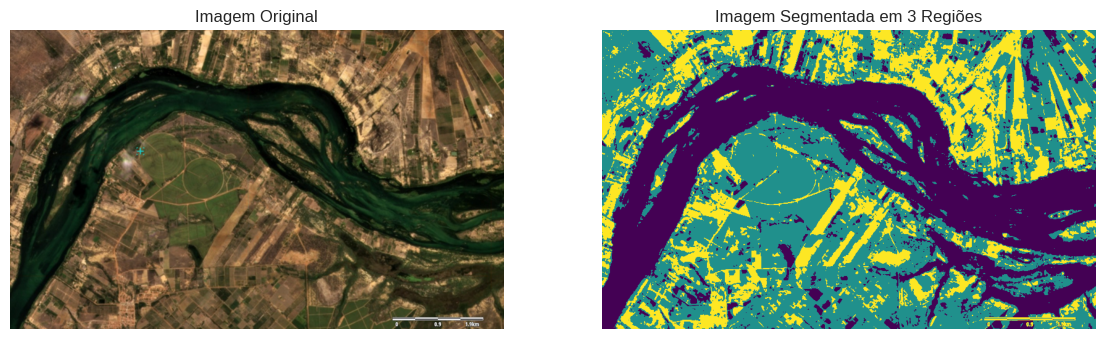

In [17]:
# Obter os rótulos e centróides do modelo de segmentação
pixel_labels_segmentation = segmentation_kmeans.labels
color_palette_segmentation = segmentation_kmeans.centroids

# Criar a imagem segmentada
segmentation_map = pixel_labels_segmentation.reshape(seg_height, seg_width)

# Visualizar a imagem original e a imagem segmentada
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(segmentation_source_image)
axes[0].set_title('Imagem Original')
axes[0].axis('off')

axes[1].imshow(segmentation_map, cmap='viridis')
axes[1].set_title(f'Imagem Segmentada em {K_segmentation} Regiões')
axes[1].axis('off')

plt.show()

## Exercícios

Neste exercício, você usará a classe `KMeans` que construímos para explorar um novo dataset e descobrir seus agrupamentos naturais.

O dataset escolhido é o **"Wine dataset"**, que contém a análise química de vinhos cultivados na mesma região da Itália, mas derivados de três cultivares (tipos de uva) diferentes. O objetivo é ver se o K-Means consegue agrupar os vinhos de acordo com seu cultivar, usando apenas as suas características químicas.

### Tarefa 1: Análise e Seleção de Features

Primeiro, carregue o dataset `wine` e use a função `seaborn.pairplot` para visualizar as relações entre as features. Analise o gráfico e escolha o par de features que você acredita que melhor separa os 3 grupos. Plote um gráfico de dispersão apenas com o par selecionado.

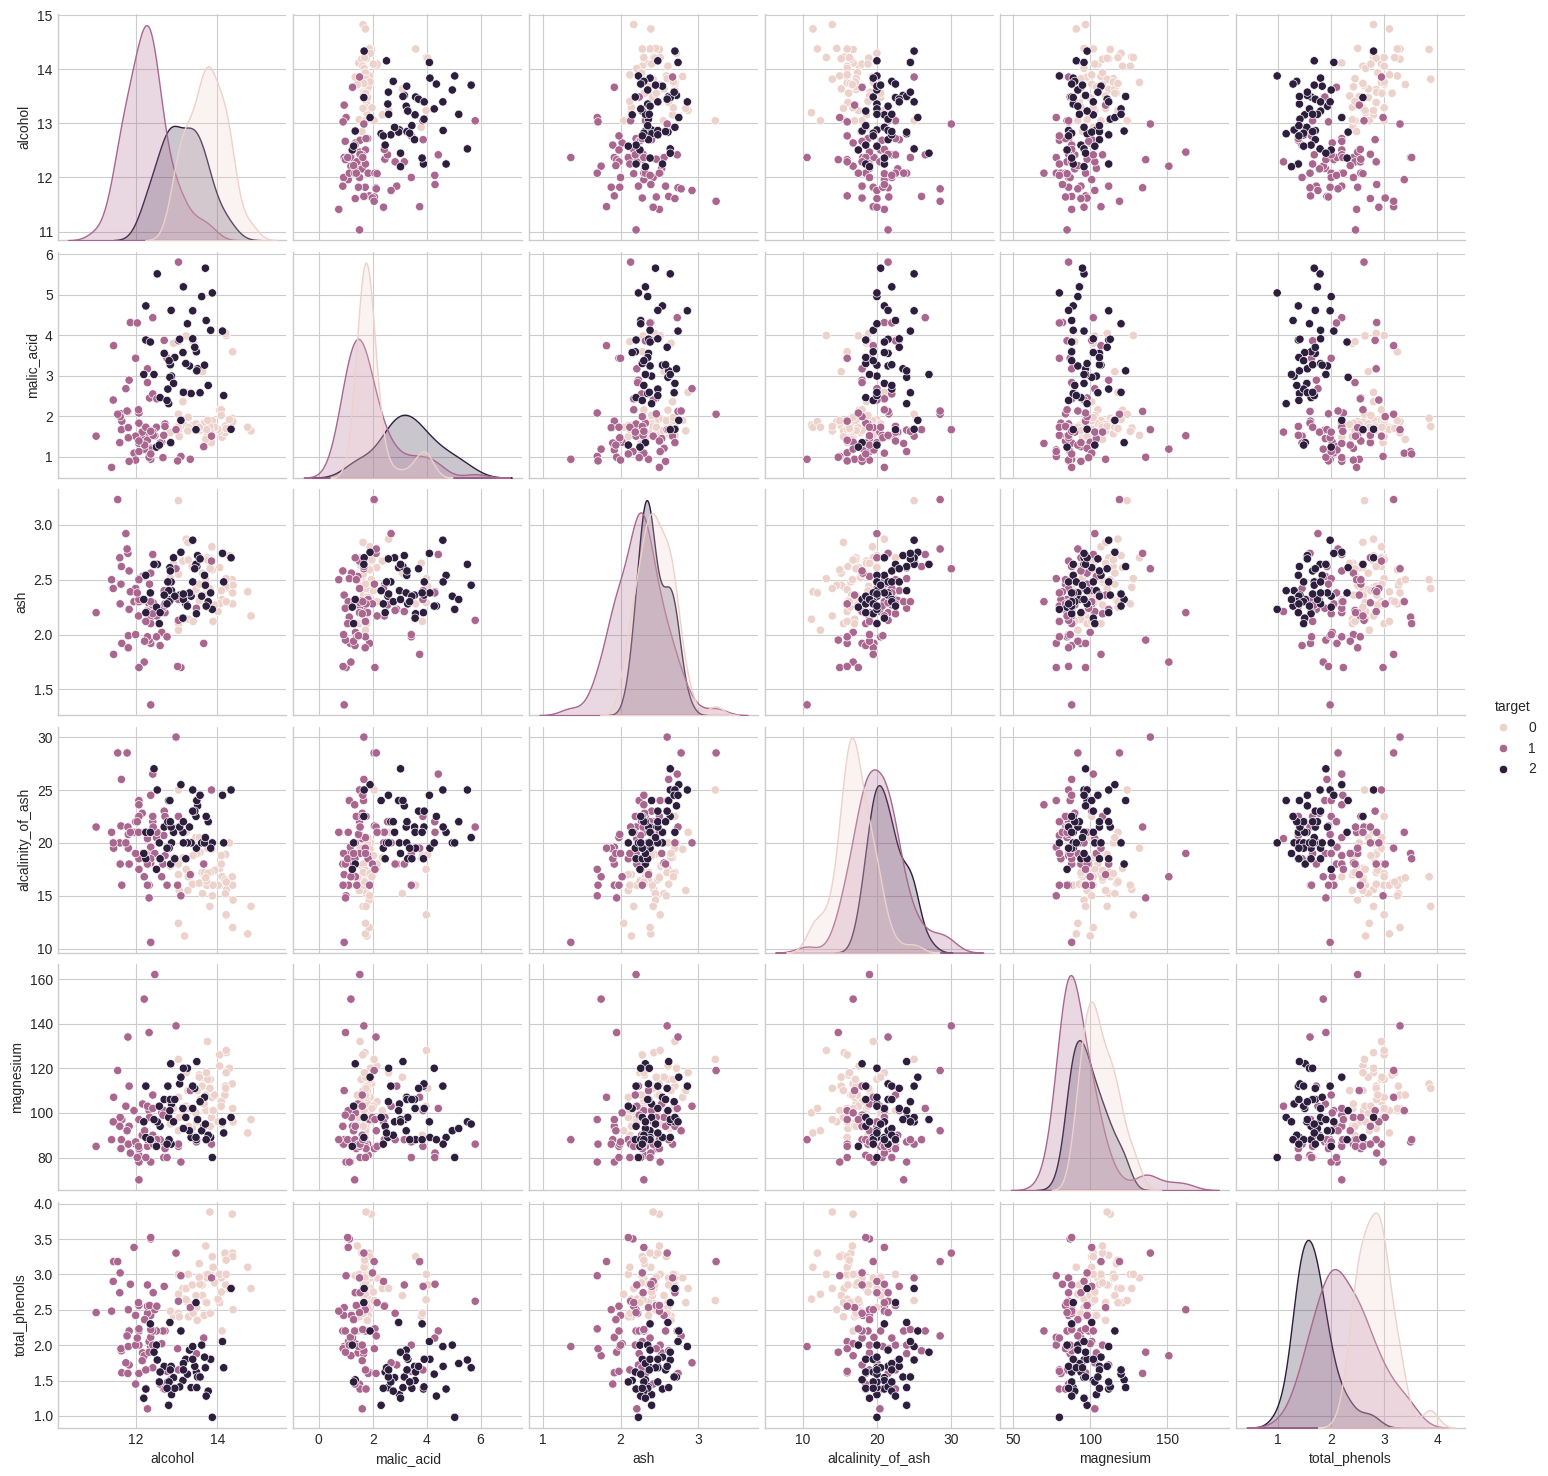

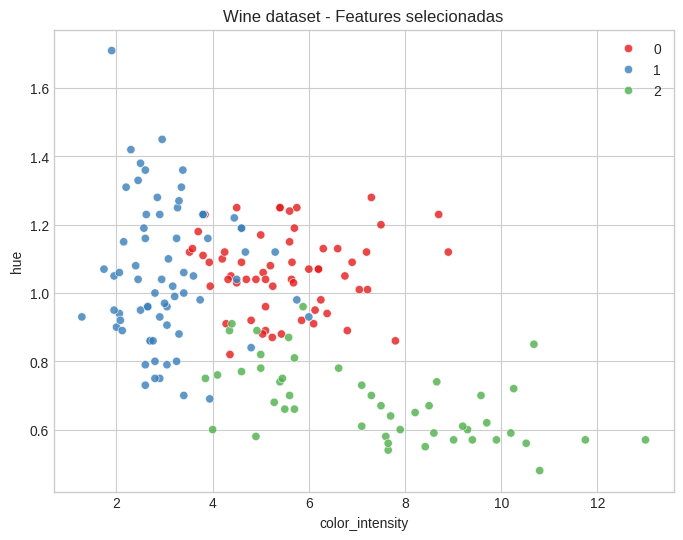

In [19]:
from sklearn.datasets import load_wine

wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target

sns.pairplot(
    pd.concat([X, pd.Series(y, name="target")], axis=1),
    vars=X.columns[:6],
    hue="target",
    diag_kind="kde"
)
plt.show()

feature_x = "color_intensity"
feature_y = "hue"

plt.figure(figsize=(8,6))
sns.scatterplot(x=X[feature_x], y=X[feature_y], hue=y, palette="Set1", alpha=0.8)
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title("Wine dataset - Features selecionadas")
plt.show()


### Tarefa 2: Encontrando o K Ótimo

Aplique o Método do Cotovelo nas duas features que você escolheu. Calcule e plote a inércia (WCSS) para K de 1 a 10. Com base no seu gráfico, qual parece ser o número ideal de clusters?

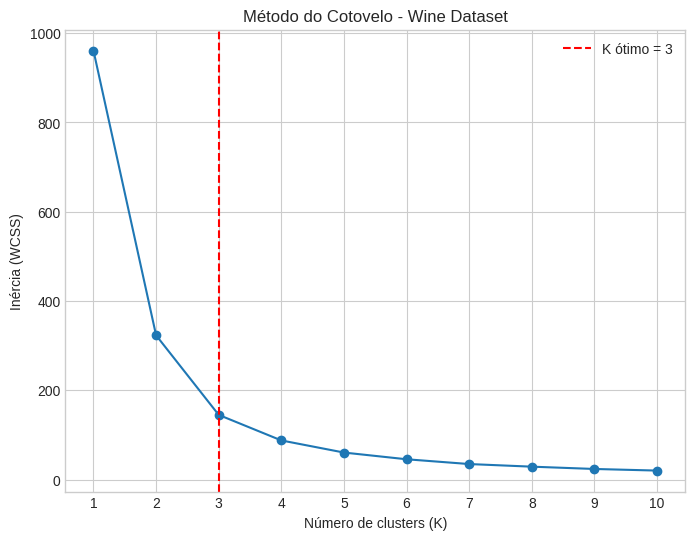

O número ideal de clusters é: 3


In [ ]:
from sklearn.cluster import KMeans

X_selected = X[[feature_x, feature_y]].values

inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_selected)
    inertias.append(kmeans.inertia_)

reducoes = [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
reducoes_relativas = [r / inertias[i-1] for i, r in enumerate(reducoes, start=1)]

optimal_k = reducoes_relativas.index(max(reducoes_relativas[1:])) + 2

plt.figure(figsize=(8,6))
plt.plot(K_range, inertias, marker='o')
plt.axvline(optimal_k, color='red', linestyle='--', label=f"K ótimo = {optimal_k}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia (WCSS)")
plt.title("Método do Cotovelo - Wine Dataset")
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.show()

print(f"O número ideal de clusters é: {optimal_k}")


### Tarefa 3: Clusterização e Avaliação

Use o K encontrado na tarefa anterior para treinar seu modelo `KMeans`. Crie um gráfico com dois subplots: um mostrando os clusters encontrados pelo algoritmo e outro mostrando os dados com os rótulos reais para comparação. Por fim, calcule a taxa de acertos e comente o resultado.

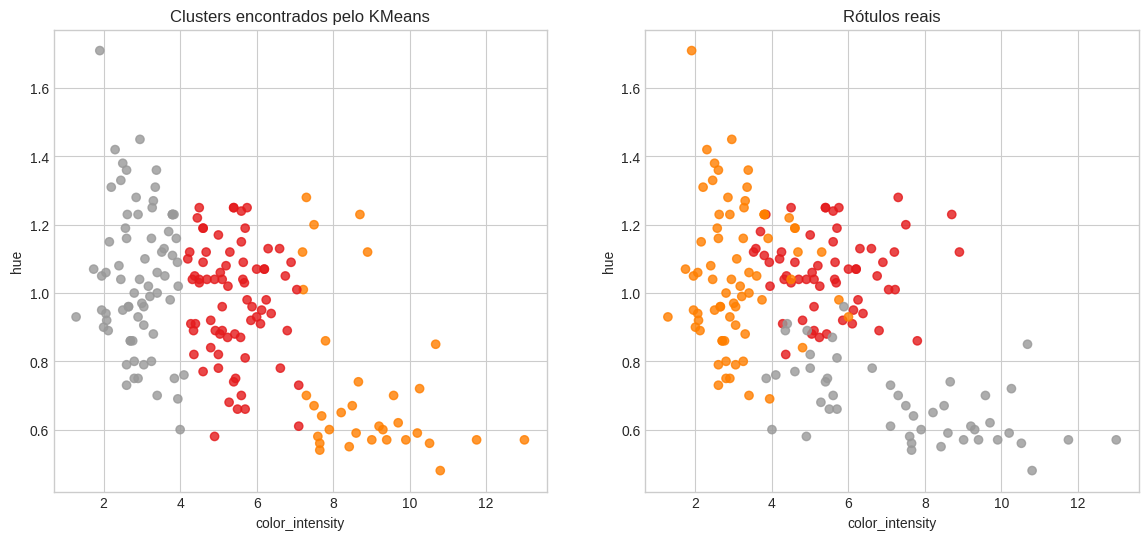

Taxa de acertos aproximada: 0.75


In [29]:
X_selected = X[[feature_x, feature_y]].values

K = optimal_k

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X_selected)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].scatter(X_selected[:,0], X_selected[:,1], c=y_pred, cmap='Set1', alpha=0.8)
axes[0].set_title("Clusters encontrados pelo KMeans")
axes[0].set_xlabel(feature_x)
axes[0].set_ylabel(feature_y)

axes[1].scatter(X_selected[:,0], X_selected[:,1], c=y, cmap='Set1', alpha=0.8)
axes[1].set_title("Rótulos reais")
axes[1].set_xlabel(feature_x)
axes[1].set_ylabel(feature_y)

plt.show()

labels = np.zeros_like(y_pred)
for i in range(K):
    mask = (y_pred == i)
    labels[mask] = mode(y[mask])[0]

accuracy = (labels == y).mean()
print(f"Taxa de acertos aproximada: {accuracy:.2f}")
